In [1]:
import os
import pickle
import sys

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F

from splice.base import carlosPlus
from splice.splice import SPLICE, SPLICECore

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
model = SPLICE(784, 784, 30, 0, 2, [256,128,64,32], [256,128,64,32][::-1], [256,128,64,32][::-1], act_fn=carlosPlus).to(device)
model.load_state_dict(torch.load("../results/models/mnist/splice_mnist_2D.pt"))

<All keys matched successfully>

In [57]:
data = np.load(
    r"C:\Users\Harris_Lab\Projects\SPLICE\data\mnist\mnist_rotated_shared-digit.npz"
)

X = torch.Tensor(data["original"][:50000]).to(device)
Y = torch.Tensor(data["rotated"][:50000]).to(device)

X_val = torch.Tensor(data["original"][50000:60000]).to(device)
Y_val = torch.Tensor(data["rotated"][50000:60000]).to(device)

X_test = torch.Tensor(data["original"][60000:]).to(device)
Y_test = torch.Tensor(data["rotated"][60000:]).to(device)
angles_test = data["angles"][60000:]
labels_test = data["labels"][60000:]

In [26]:
a_shared_subm, b_shared_subm, a_private_subm, b_private_subm = SPLICE.project_to_submanifolds(model, X_test, Y_test)

In [27]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=2)
nn.fit(Y_test.detach().cpu().numpy())
distances, indices = nn.kneighbors(Y_test.detach().cpu().numpy())
data_nn = distances[:,1]

distances, indices = nn.kneighbors(b_private_subm.detach().cpu().numpy())
private_nn = distances[:,0]

distances, indices = nn.kneighbors(b_shared_subm.detach().cpu().numpy())
shared_nn = distances[:, 0]

In [58]:
from scipy.spatial.distance import cdist
X_test = X_test.detach().cpu().numpy()
avg_within_class = 0
for i in range(10):
    print(i)
    dists = cdist(X_test[labels_test == i], X_test[labels_test == i])
    avg_within_class += dists.mean()/10

avg_within_class

0
1
2
3
4
5
6
7
8
9


8.948847014728424

In [59]:
from scipy.spatial.distance import cdist
avg_cross_class = 0
for i in range(10):
    print(i)
    dists = cdist(X_test[labels_test == i], X_test[labels_test != i])
    avg_cross_class += dists.mean()/10

avg_cross_class

0
1
2
3
4
5
6
7
8
9


10.334527444693878

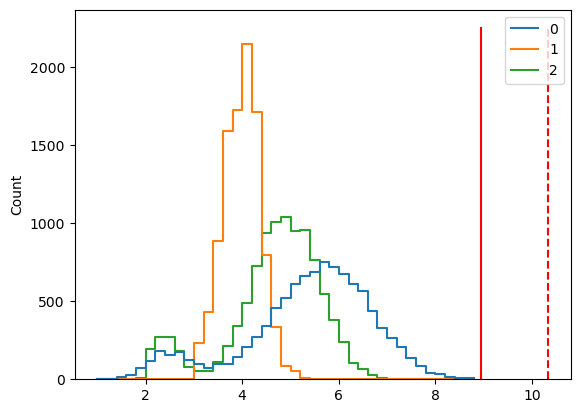

In [60]:
sns.histplot([data_nn, private_nn, shared_nn], bins=np.arange(1,9,0.2), element='step', fill=False)
ylim1 =  plt.ylim()[1]
plt.vlines(avg_within_class, plt.ylim()[0], ylim1, color='r')
plt.vlines(avg_cross_class, plt.ylim()[0], ylim1, color='r', linestyles='dashed')
plt.savefig("../figures/arxiv_figures/mnist_nns.svg", transparent=True, dpi=300)